# CAPSTONE INVESTIGACIÓN OPERATIVA

In [1]:
#encender .venv
!.\.venv\Scripts\activate.bat

### Instalación de dependencias en el .venv

In [16]:
# Instala y actualiza los paquetes necesarios
%pip install --upgrade pip
%pip install numpy==2.2 pandas scikit-learn matplotlib joblib gurobipy gurobi-machinelearning pandas-datareader xgboost shap optuna seaborn

# Verifica la versión de scikit-learn y Python
import sklearn, sys
print("Python version:", sys.version)
print("scikit-learn version:", sklearn.__version__)

# Importa y verifica pandas_datareader
import importlib
import pandas_datareader as pdr
print("pandas_datareader OK:", importlib.metadata.version("pandas-datareader"))

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
scikit-learn version: 1.7.1
pandas_datareader OK: 0.10.0


### Importamos Librerias necesarias

In [3]:
# ============ Config & IO ============
import re
import time
#importamos numpy version 2.2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # muestra todas las columnas

# ============ Scikit-learn ============
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
# ===== IMPORTS extra =====
from sklearn.base import clone           # por si no lo tenías
from xgboost import XGBRegressor         # pip install xgboost


# ============ Gurobi / MIP ============
import gurobipy as gp
from gurobipy import GRB
from gurobi_ml import add_predictor_constr

# ============ Datos externos (opcional) ============
from pandas_datareader.data import DataReader  # si usas FRED/CPI
from sklearn.base import clone

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Prepocesamiento de la base de datos "AmesHousing"

In [4]:
FILE = "ames_dum.csv"
df = pd.read_csv(FILE)
df.head()


,Lot_Frontage,Lot_Area,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Sale_Price,Longitude,Latitude,Sale_Price_Log,MS_SubClass_One_Story_1945_and_Older,MS_SubClass_One_Story_with_Finished_Attic_All_Ages,MS_SubClass_One_and_Half_Story_Unfinished_All_Ages,MS_SubClass_One_and_Half_Story_Finished_All_Ages,MS_SubClass_Two_Story_1946_and_Newer,MS_SubClass_Two_Story_1945_and_Older,MS_SubClass_Two_and_Half_Story_All_Ages,MS_SubClass_Split_or_Multilevel,MS_SubClass_Split_Foyer,MS_SubClass_Duplex_All_Styles_and_Ages,MS_SubClass_One_Story_PUD_1946_and_Newer,MS_SubClass_One_and_Half_Story_PUD_All_Ages,MS_SubClass_Two_Story_PUD_1946_and_Newer,MS_SubClass_PUD_Multilevel_Split_Level_Foyer,MS_SubClass_Two_Family_conversion_All_Styles_and_Ages,MS_Zoning_Residential_High_Density,MS_Zoning_Residential_Low_Density,MS_Zoning_Residential_Medium_Density,MS_Zoning_A_agr,MS_Zoning_C_all,MS_Zoning_I_all,Lot_Shape_Slightly_Irregular,Lot_Shape_Moderately_Irregular,Lot_Shape_Irregular,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl,Lot_Config_CulDSac,Lot_Config_FR2,Lot_Config_FR3,Lot_Config_Inside,Neighborhood_College_Creek,Neighborhood_Old_Town,Neighborhood_Edwards,Neighborhood_Somerset,Neighborhood_Northridge_Heights,Neighborhood_Gilbert,Neighborhood_Sawyer,Neighborhood_Northwest_Ames,Neighborhood_Sawyer_West,Neighborhood_Mitchell,Neighborhood_Brookside,Neighborhood_Crawford,Neighborhood_Iowa_DOT_and_Rail_Road,Neighborhood_Timberland,Neighborhood_Northridge,Neighborhood_Stone_Brook,Neighborhood_South_and_West_of_Iowa_State_University,Neighborhood_Clear_Creek,Neighborhood_Meadow_Village,Neighborhood_Briardale,Neighborhood_Bloomington_Heights,Neighborhood_Veenker,Neighborhood_Northpark_Villa,Neighborhood_Blueste,Neighborhood_Greens,Neighborhood_Green_Hills,Neighborhood_Landmark,Neighborhood_Hayden_Lake,Condition_1_Feedr,Condition_1_Norm,Condition_1_PosA,Condition_1_PosN,Condition_1_RRAe,Condition_1_RRAn,Condition_1_RRNe,Condition_1_RRNn,Bldg_Type_TwoFmCon,Bldg_Type_Duplex,Bldg_Type_Twnhs,Bldg_Type_TwnhsE,House_Style_One_and_Half_Unf,House_Style_One_Story,House_Style_SFoyer,House_Style_SLvl,House_Style_Two_and_Half_Fin,House_Style_Two_and_Half_Unf,House_Style_Two_Story,Roof_Style_Gable,Roof_Style_Gambrel,Roof_Style_Hip,Roof_Style_Mansard,Roof_Style_Shed,Roof_Matl_CompShg,Roof_Matl_Membran,Roof_Matl_Metal,Roof_Matl_Roll,Roof_Matl_Tar&Grv,Roof_Matl_WdShake,Roof_Matl_WdShngl,Exterior_1st_AsphShn,Exterior_1st_BrkComm,Exterior_1st_BrkFace,Exterior_1st_CBlock,Exterior_1st_CemntBd,Exterior_1st_HdBoard,Exterior_1st_ImStucc,Exterior_1st_MetalSd,Exterior_1st_Plywood,Exterior_1st_PreCast,Exterior_1st_Stone,Exterior_1st_Stucco,Exterior_1st_VinylSd,Exterior_1st_Wd Sdng,Exterior_1st_WdShing,Exterior_2nd_AsphShn,Exterior_2nd_Brk Cmn,Exterior_2nd_BrkFace,Exterior_2nd_CBlock,Exterior_2nd_CmentBd,Exterior_2nd_HdBoard,Exterior_2nd_ImStucc,Exterior_2nd_MetalSd,Exterior_2nd_Other,Exterior_2nd_Plywood,Exterior_2nd_PreCast,Exterior_2nd_Stone,Exterior_2nd_Stucco,Exterior_2nd_VinylSd,Exterior_2nd_Wd Sdng,Exterior_2nd_Wd Shng,Mas_Vnr_Type_BrkFace,Mas_Vnr_Type_CBlock,Mas_Vnr_Type_None,Mas_Vnr_Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central_Air_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Unknown,Garage_Type_Basment,Garage_Type_BuiltIn,Garage_Type_CarPort,Garage_Type_Detchd,Garage_Type_More_Than_Two_Types,Garage_Type_No_Garage,Sale_Type

In [ ]:



def rmse_compat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:  # versiones viejas de sklearn
        return np.sqrt(mean_squared_error(y_true, y_pred))



y_real = df["Sale_Price_Log"].copy()
X = df.drop(columns=[
    "Sale_Price", "Sale_Price_Log", "Overall_Qual",


    # Variables irrelevantes (importancia ≈ 0)
    "Neighborhood_Sawyer_West","Kitchen_AbvGr","Exterior_1st_VinylSd","Mas_Vnr_Type_BrkFace",
    "MS_SubClass_Two_Story_1945_and_Older","Condition_1_PosN","Neighborhood_Northridge",
    "Exterior_2nd_Stucco","Exterior_2nd_MetalSd","Sale_Condition_Alloca","Enclosed_Porch",
    "Neighborhood_Mitchell","Mas_Vnr_Type_None","Bsmt_Cond","Land_Contour_Low",
    "Sale_Condition_AdjLand","Land_Contour_HLS","Lot_Frontage","Electrical_SBrkr",
    "Exterior_2nd_HdBoard","Pool_Area","Bldg_Type_TwoFmCon","Roof_Matl_CompShg",
    "Exterior_2nd_Plywood","MS_Zoning_Residential_High_Density","Exterior_1st_Plywood",
    "Condition_1_PosA","Lot_Shape_Slightly_Irregular","Condition_1_RRAe",
    "MS_SubClass_Two_and_Half_Story_All_Ages","Neighborhood_Stone_Brook","BsmtFin_SF_2",
    "Mas_Vnr_Type_Stone","Neighborhood_Green_Hills","Lot_Config_CulDSac",
    "MS_SubClass_Duplex_All_Styles_and_Ages","Garage_Type_CarPort","Heating_GasW",
    "Sale_Type_ConLD","Sale_Type_Oth","Roof_Style_Gable","Garage_Type_Basment",
    "House_Style_Two_Story","Lot_Config_Inside","BsmtFin_Type_2","Lot_Shape_Irregular",
    "Sale_Type_ConLw","Neighborhood_Gilbert","MS_SubClass_Two_Family_conversion_All_Styles_and_Ages",
    "Exterior_1st_Stucco","Low_Qual_Fin_SF","Exterior_2nd_Wd Sdng","Exterior_1st_MetalSd",
    "MS_SubClass_Split_Foyer","Roof_Style_Gambrel","Heating_Grav","Bsmt_Half_Bath",
    "Neighborhood_Timberland","Neighborhood_Northridge_Heights","Garage_Type_BuiltIn",
    "Exterior_1st_CemntBd","Neighborhood_Bloomington_Heights","MS_SubClass_Two_Story_PUD_1946_and_Newer",
    "Foundation_Stone","Neighborhood_Meadow_Village","Heating_Wall","House_Style_Two_and_Half_Unf",
    "Neighborhood_Veenker","Foundation_Slab","Exterior_2nd_BrkFace","Lot_Config_FR3",
    "Misc_Val","Three_season_porch","Electrical_FuseF","Neighborhood_College_Creek",
    "Lot_Shape_Moderately_Irregular","Exterior_1st_HdBoard","Bldg_Type_TwnhsE",
    "Exterior_2nd_Wd Shng","MS_SubClass_Split_or_Multilevel","Exterior_2nd_ImStucc",
    "Condition_1_RRNn","Exterior_1st_WdShing","House_Style_SFoyer","Roof_Matl_WdShake",
    "MS_Zoning_A_agr","MS_Zoning_I_all","MS_SubClass_PUD_Multilevel_Split_Level_Foyer",
    "MS_SubClass_One_and_Half_Story_Unfinished_All_Ages","MS_SubClass_One_Story_with_Finished_Attic_All_Ages",
    "MS_SubClass_One_and_Half_Story_PUD_All_Ages","Neighborhood_Hayden_Lake","Neighborhood_Greens",
    "Neighborhood_Blueste","Neighborhood_Northpark_Villa","Neighborhood_Briardale",
    "Neighborhood_Landmark","Bldg_Type_Twnhs","House_Style_Two_and_Half_Fin","Condition_1_RRAn",
    "Exterior_1st_ImStucc","Exterior_1st_CBlock","Exterior_1st_AsphShn","Exterior_1st_BrkComm",
    "Roof_Matl_WdShngl","Roof_Style_Shed","Roof_Matl_Roll","Roof_Matl_Metal","Roof_Style_Mansard",
    "Roof_Matl_Membran","Condition_1_RRNe","Bldg_Type_Duplex","House_Style_One_and_Half_Unf",
    "Exterior_1st_Stone","Exterior_2nd_AsphShn","Exterior_2nd_Brk Cmn","Mas_Vnr_Type_CBlock",
    "Exterior_2nd_Stone","Exterior_2nd_Other","Exterior_2nd_PreCast","Exterior_1st_PreCast",
    "Exterior_2nd_CBlock","Foundation_Wood","Heating_OthW","Electrical_Mix","Electrical_FuseP",
    "Electrical_Unknown","Sale_Type_Con","Sale_Type_CWD","Sale_Type_ConLI",
    "Garage_Type_More_Than_Two_Types", "Sale_Type_VWD", "Garage_Type_No_Garage"
]).copy()


feats = X.columns.tolist()
medians = X.median(numeric_only=True)
X   = X.fillna(medians).copy()     # <- sin NaN
# ====== 3) Modelos (Pipelines): Lineal y GBR ======
# ====== 3) Modelos (Pipelines): Lineal, GBR y XGBoost ======
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("est", LinearRegression())
    ]),
    "GBR": Pipeline([
        ("scaler", StandardScaler()),
        ("est", GradientBoostingRegressor(
            learning_rate=0.05, n_estimators=400, max_depth=3,
            subsample=0.9, random_state=42
        ))
    ]),
    "XGB": Pipeline([
        ("scaler", "passthrough"),   # árboles no necesitan escalado
        ("est", XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=2,
            reg_lambda=5.0,
            n_jobs=-1,
            tree_method="hist",
            random_state=42
        ))
    ])
}


def cv_eval(estimator, X, y_log, folds=5, seed=42):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    y_true, y_pred = [], []
    for tr, te in kf.split(X):
        Xt, Xv = X.iloc[tr], X.iloc[te]
        yt, yv = y_log.iloc[tr], y_log.iloc[te]
        m = clone(estimator)
        m.fit(Xt, yt)
        pv = np.expm1(m.predict(Xv))  # de log a precio real
        y_true.append(np.expm1(yv)); y_pred.append(pv)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return {
        "RMSE": rmse_compat(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# ====== 4) Evaluación y entrenamiento final ======
rows, fitted = [], {}
for name, est in models.items():
    metrics = cv_eval(est, X, y_real)
    rows.append({"model": name, **{k: round(v,3) for k,v in metrics.items()}})
    est.fit(X, y_real)          # entrena full para el “modelo final”
    fitted[name] = est

results = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print(results)

best_name = results.iloc[0]["model"]
best_model = fitted[best_name]
print(f"\nGanador por RMSE (CV): {best_name}")

# ====== 5) Interpretabilidad básica para el informe ======
# ====== 5) Interpretabilidad básica para el informe ======
if best_name == "Linear":
    lr = best_model.named_steps["est"]
    coefs = pd.Series(lr.coef_.ravel(), index=feats).sort_values(key=np.abs, ascending=False)
    print("\nCoeficientes (ordenados por |coef|) — escala estandarizada:")
    print(coefs.to_string())
else:
    # Sirve tanto para GBR como para XGB
    tree_est = best_model.named_steps["est"]
    imps = pd.Series(tree_est.feature_importances_, index=feats).sort_values(ascending=False)
    print(f"\nImportancias de características ({best_name}):")
    print(imps.to_string())


# Para usar más tarde en Gurobi:
trained_feats = feats
trained_stats = pd.DataFrame({"q05": X.quantile(0.05), "median": X.median(), "q95": X.quantile(0.95)})
best_linear_model = fitted["Linear"]
best_gbr_model    = fitted["GBR"]



    model       RMSE        MAE     R2
0     XGB  35021.242  22420.357  0.920
1     GBR  36083.790  23039.584  0.915
2  Linear  67795.358  27540.930  0.699

Ganador por RMSE (CV): XGB

Importancias de características (XGB):
Exter_Qual                                              0.280632
Garage_Cars                                             0.088082
Kitchen_Qual                                            0.079378
MS_SubClass_Two_Story_1946_and_Newer                    0.045774
Garage_Cond                                             0.044590
Fireplaces                                              0.041419
Bsmt_Qual                                               0.034977
Central_Air_Y                                           0.034576
Year_Built                                              0.031066
MS_Zoning_Residential_Low_Density                       0.020948
MS_SubClass_One_Story_1945_and_Older                    0.020929
Full_Bath                                               0.020

In [11]:
X.shape

(2930, 74)

In [12]:
# ====== 8) Optuna: búsqueda de hiperparámetros para XGBoost ======
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "n_jobs": -1,
        "tree_method": "hist",
        "random_state": 42
    }

    model = XGBRegressor(**params)
    pipe = Pipeline([("scaler", "passthrough"), ("est", model)])

    metrics = cv_eval(pipe, X, y_real, folds=5)
    return metrics["RMSE"]

# Crear estudio (minimizar RMSE)
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n==== Optuna: Mejores hiperparámetros ====")
print(study.best_params)
print(f"Mejor RMSE CV: {study.best_value:.4f}")
print(f"R2 CV: {metrics['R2']:.4f}")

# Entrenar modelo final con los mejores hiperparámetros
best_params = study.best_params
best_xgb_optuna = XGBRegressor(**best_params)
best_xgb_optuna.fit(X, y_real)

# Guardar para compararlo con el resto
fitted["XGB_Optuna"] = best_xgb_optuna




c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-07 21:25:42,395] A new study created in memory with name: no-name-b268fe82-f1b9-4584-8f68-140db22ff46e
Best trial: 0. Best value: 42567.3:   2%|▏         | 1/50 [00:07<05:51,  7.18s/it]

[I 2025-10-07 21:25:49,579] Trial 0 finished with value: 42567.25426765622 and parameters: {'n_estimators': 637, 'learning_rate': 0.17254716573280354, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 2, 'reg_lambda': 0.13066739238053282}. Best is trial 0 with value: 42567.25426765622.


Best trial: 1. Best value: 36696:   4%|▍         | 2/50 [00:31<13:41, 17.11s/it]  

[I 2025-10-07 21:26:13,626] Trial 1 finished with value: 36695.96285630851 and parameters: {'n_estimators': 1080, 'learning_rate': 0.06054365855469246, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'min_child_weight': 9, 'reg_lambda': 0.26587543983272705}. Best is trial 1 with value: 36695.96285630851.


Best trial: 1. Best value: 36696:   6%|▌         | 3/50 [00:41<10:47, 13.78s/it]

[I 2025-10-07 21:26:23,453] Trial 2 finished with value: 37505.273036209954 and parameters: {'n_estimators': 463, 'learning_rate': 0.017322667470546258, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'min_child_weight': 3, 'reg_lambda': 1.6738085788752133}. Best is trial 1 with value: 36695.96285630851.


Best trial: 3. Best value: 36547.4:   8%|▊         | 4/50 [00:45<07:52, 10.27s/it]

[I 2025-10-07 21:26:28,337] Trial 3 finished with value: 36547.35225496222 and parameters: {'n_estimators': 425, 'learning_rate': 0.023993242906812727, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'min_child_weight': 2, 'reg_lambda': 1.0677482709481354}. Best is trial 3 with value: 36547.35225496222.


Best trial: 3. Best value: 36547.4:  10%|█         | 5/50 [00:55<07:31, 10.03s/it]

[I 2025-10-07 21:26:37,954] Trial 4 finished with value: 37445.02247942125 and parameters: {'n_estimators': 833, 'learning_rate': 0.011492999300221412, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'min_child_weight': 10, 'reg_lambda': 8.536189862866832}. Best is trial 3 with value: 36547.35225496222.


Best trial: 3. Best value: 36547.4:  12%|█▏        | 6/50 [01:00<06:04,  8.28s/it]

[I 2025-10-07 21:26:42,820] Trial 5 finished with value: 38139.81850413965 and parameters: {'n_estimators': 1028, 'learning_rate': 0.0249064396938244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'reg_lambda': 0.978033701665941}. Best is trial 3 with value: 36547.35225496222.


Best trial: 6. Best value: 35982.4:  14%|█▍        | 7/50 [01:02<04:28,  6.24s/it]

[I 2025-10-07 21:26:44,871] Trial 6 finished with value: 35982.37518604616 and parameters: {'n_estimators': 330, 'learning_rate': 0.15242391728466367, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'min_child_weight': 6, 'reg_lambda': 1.2399967836846095}. Best is trial 6 with value: 35982.37518604616.


Best trial: 6. Best value: 35982.4:  16%|█▌        | 8/50 [01:16<06:10,  8.83s/it]

[I 2025-10-07 21:26:59,249] Trial 7 finished with value: 39027.419846303295 and parameters: {'n_estimators': 466, 'learning_rate': 0.18258230439200238, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'min_child_weight': 6, 'reg_lambda': 6.978281265126034}. Best is trial 6 with value: 35982.37518604616.


Best trial: 6. Best value: 35982.4:  18%|█▊        | 9/50 [01:18<04:35,  6.71s/it]

[I 2025-10-07 21:27:01,294] Trial 8 finished with value: 47198.64877850117 and parameters: {'n_estimators': 379, 'learning_rate': 0.017987863473362915, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'min_child_weight': 3, 'reg_lambda': 4.544383960336017}. Best is trial 6 with value: 35982.37518604616.


Best trial: 6. Best value: 35982.4:  20%|██        | 10/50 [01:31<05:38,  8.45s/it]

[I 2025-10-07 21:27:13,650] Trial 9 finished with value: 36955.58917564825 and parameters: {'n_estimators': 621, 'learning_rate': 0.023200867504756827, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'min_child_weight': 1, 'reg_lambda': 9.413993046829944}. Best is trial 6 with value: 35982.37518604616.


Best trial: 6. Best value: 35982.4:  22%|██▏       | 11/50 [01:48<07:18, 11.24s/it]

[I 2025-10-07 21:27:31,199] Trial 10 finished with value: 39010.49211675333 and parameters: {'n_estimators': 762, 'learning_rate': 0.08292797530014898, 'max_depth': 10, 'subsample': 0.9352468198873464, 'colsample_bytree': 0.6363434386005423, 'min_child_weight': 6, 'reg_lambda': 0.5279879280175432}. Best is trial 6 with value: 35982.37518604616.


Best trial: 6. Best value: 35982.4:  24%|██▍       | 12/50 [01:56<06:24, 10.11s/it]

[I 2025-10-07 21:27:38,729] Trial 11 finished with value: 36268.32318127295 and parameters: {'n_estimators': 310, 'learning_rate': 0.04374085254523356, 'max_depth': 4, 'subsample': 0.6938137307743037, 'colsample_bytree': 0.8485779491700473, 'min_child_weight': 5, 'reg_lambda': 2.1704555036389435}. Best is trial 6 with value: 35982.37518604616.


Best trial: 12. Best value: 35266.5:  26%|██▌       | 13/50 [02:03<05:41,  9.22s/it]

[I 2025-10-07 21:27:45,888] Trial 12 finished with value: 35266.4776446166 and parameters: {'n_estimators': 315, 'learning_rate': 0.09589983842092037, 'max_depth': 4, 'subsample': 0.8838129988503955, 'colsample_bytree': 0.7957716762981599, 'min_child_weight': 8, 'reg_lambda': 2.41757171102908}. Best is trial 12 with value: 35266.4776446166.


Best trial: 12. Best value: 35266.5:  28%|██▊       | 14/50 [02:09<04:51,  8.11s/it]

[I 2025-10-07 21:27:51,444] Trial 13 finished with value: 35381.60761654039 and parameters: {'n_estimators': 589, 'learning_rate': 0.10941406022944634, 'max_depth': 4, 'subsample': 0.8775346755602169, 'colsample_bytree': 0.8027385735100352, 'min_child_weight': 8, 'reg_lambda': 2.654334209893317}. Best is trial 12 with value: 35266.4776446166.


Best trial: 14. Best value: 35089.2:  30%|███       | 15/50 [02:12<03:51,  6.63s/it]

[I 2025-10-07 21:27:54,635] Trial 14 finished with value: 35089.20239665398 and parameters: {'n_estimators': 603, 'learning_rate': 0.11043890194564951, 'max_depth': 3, 'subsample': 0.8943819933031404, 'colsample_bytree': 0.8029222041304702, 'min_child_weight': 8, 'reg_lambda': 2.8663929519430518}. Best is trial 14 with value: 35089.20239665398.


Best trial: 15. Best value: 34628.3:  32%|███▏      | 16/50 [02:17<03:28,  6.13s/it]

[I 2025-10-07 21:27:59,601] Trial 15 finished with value: 34628.34525082168 and parameters: {'n_estimators': 917, 'learning_rate': 0.08903012950316422, 'max_depth': 3, 'subsample': 0.9040330172235821, 'colsample_bytree': 0.7739222908576203, 'min_child_weight': 8, 'reg_lambda': 4.016520195558671}. Best is trial 15 with value: 34628.34525082168.


Best trial: 15. Best value: 34628.3:  34%|███▍      | 17/50 [02:23<03:24,  6.20s/it]

[I 2025-10-07 21:28:05,973] Trial 16 finished with value: 37853.567984351605 and parameters: {'n_estimators': 911, 'learning_rate': 0.04428251345736053, 'max_depth': 2, 'subsample': 0.9917796630679625, 'colsample_bytree': 0.7770131184958838, 'min_child_weight': 8, 'reg_lambda': 4.425825489394285}. Best is trial 15 with value: 34628.34525082168.


Best trial: 17. Best value: 34528.1:  36%|███▌      | 18/50 [02:39<04:49,  9.03s/it]

[I 2025-10-07 21:28:21,601] Trial 17 finished with value: 34528.082748979825 and parameters: {'n_estimators': 939, 'learning_rate': 0.06477846839716143, 'max_depth': 3, 'subsample': 0.9188697853698146, 'colsample_bytree': 0.8496887367498009, 'min_child_weight': 10, 'reg_lambda': 4.162412783350156}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  38%|███▊      | 19/50 [03:14<08:40, 16.80s/it]

[I 2025-10-07 21:28:56,481] Trial 18 finished with value: 36805.04018106454 and parameters: {'n_estimators': 1177, 'learning_rate': 0.06130244251381504, 'max_depth': 6, 'subsample': 0.9298249375977756, 'colsample_bytree': 0.8609727402803514, 'min_child_weight': 10, 'reg_lambda': 4.457887215652758}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  40%|████      | 20/50 [03:29<08:13, 16.44s/it]

[I 2025-10-07 21:29:12,093] Trial 19 finished with value: 34814.55747922182 and parameters: {'n_estimators': 938, 'learning_rate': 0.061983056586556604, 'max_depth': 3, 'subsample': 0.7715607893043632, 'colsample_bytree': 0.8448372126058836, 'min_child_weight': 9, 'reg_lambda': 0.4371993126708942}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  42%|████▏     | 21/50 [03:46<07:58, 16.52s/it]

[I 2025-10-07 21:29:28,782] Trial 20 finished with value: 34880.207698593054 and parameters: {'n_estimators': 988, 'learning_rate': 0.0746963582508658, 'max_depth': 3, 'subsample': 0.9480498982825372, 'colsample_bytree': 0.9311102255784347, 'min_child_weight': 7, 'reg_lambda': 5.65418403285389}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  44%|████▍     | 22/50 [03:59<07:10, 15.37s/it]

[I 2025-10-07 21:29:41,496] Trial 21 finished with value: 34783.19131192492 and parameters: {'n_estimators': 900, 'learning_rate': 0.03824743743979973, 'max_depth': 3, 'subsample': 0.7856701644132245, 'colsample_bytree': 0.8407434980706122, 'min_child_weight': 10, 'reg_lambda': 0.6337711639952185}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  46%|████▌     | 23/50 [04:08<06:02, 13.44s/it]

[I 2025-10-07 21:29:50,432] Trial 22 finished with value: 35782.57750455879 and parameters: {'n_estimators': 845, 'learning_rate': 0.03417504338880524, 'max_depth': 5, 'subsample': 0.8369494255842972, 'colsample_bytree': 0.7384588413716073, 'min_child_weight': 10, 'reg_lambda': 0.5212673661961978}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  48%|████▊     | 24/50 [04:14<04:58, 11.49s/it]

[I 2025-10-07 21:29:57,359] Trial 23 finished with value: 34579.74457823009 and parameters: {'n_estimators': 1135, 'learning_rate': 0.04067235676346911, 'max_depth': 3, 'subsample': 0.9113755548698836, 'colsample_bytree': 0.837377977502736, 'min_child_weight': 9, 'reg_lambda': 0.8073376787675359}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  50%|█████     | 25/50 [04:26<04:45, 11.41s/it]

[I 2025-10-07 21:30:08,578] Trial 24 finished with value: 37655.178774414126 and parameters: {'n_estimators': 1195, 'learning_rate': 0.13508909565212412, 'max_depth': 5, 'subsample': 0.9102055180959733, 'colsample_bytree': 0.7641700931792714, 'min_child_weight': 9, 'reg_lambda': 0.779233374698931}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  52%|█████▏    | 26/50 [04:33<04:02, 10.09s/it]

[I 2025-10-07 21:30:15,604] Trial 25 finished with value: 37547.36205501312 and parameters: {'n_estimators': 1119, 'learning_rate': 0.031371647918728235, 'max_depth': 2, 'subsample': 0.9851831451523586, 'colsample_bytree': 0.8854772201500394, 'min_child_weight': 7, 'reg_lambda': 0.3469902168819178}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  54%|█████▍    | 27/50 [04:38<03:21,  8.78s/it]

[I 2025-10-07 21:30:21,325] Trial 26 finished with value: 34645.46600237045 and parameters: {'n_estimators': 1038, 'learning_rate': 0.05357890379237118, 'max_depth': 3, 'subsample': 0.8642095814696827, 'colsample_bytree': 0.8226576620336251, 'min_child_weight': 9, 'reg_lambda': 1.6871483815866508}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  56%|█████▌    | 28/50 [04:46<03:04,  8.38s/it]

[I 2025-10-07 21:30:28,767] Trial 27 finished with value: 37332.12617400472 and parameters: {'n_estimators': 734, 'learning_rate': 0.1300562485823932, 'max_depth': 6, 'subsample': 0.9500356189292235, 'colsample_bytree': 0.6736701896523487, 'min_child_weight': 7, 'reg_lambda': 3.2939409598738383}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  58%|█████▊    | 29/50 [05:03<03:48, 10.87s/it]

[I 2025-10-07 21:30:45,460] Trial 28 finished with value: 40182.641463219545 and parameters: {'n_estimators': 973, 'learning_rate': 0.07762339351108556, 'max_depth': 10, 'subsample': 0.8104309334272103, 'colsample_bytree': 0.9295328450278704, 'min_child_weight': 5, 'reg_lambda': 0.22076001499514056}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  60%|██████    | 30/50 [05:09<03:09,  9.46s/it]

[I 2025-10-07 21:30:51,635] Trial 29 finished with value: 35655.96571838568 and parameters: {'n_estimators': 757, 'learning_rate': 0.048496172566047026, 'max_depth': 5, 'subsample': 0.9097065176596599, 'colsample_bytree': 0.760638848780667, 'min_child_weight': 9, 'reg_lambda': 1.692342463056943}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  62%|██████▏   | 31/50 [05:13<02:31,  7.96s/it]

[I 2025-10-07 21:30:56,079] Trial 30 finished with value: 38021.26446026965 and parameters: {'n_estimators': 1106, 'learning_rate': 0.02963701033357897, 'max_depth': 2, 'subsample': 0.9940375554529562, 'colsample_bytree': 0.592141041606984, 'min_child_weight': 10, 'reg_lambda': 0.11066458861901475}. Best is trial 17 with value: 34528.082748979825.


Best trial: 17. Best value: 34528.1:  64%|██████▍   | 32/50 [05:18<02:08,  7.16s/it]

[I 2025-10-07 21:31:01,373] Trial 31 finished with value: 34764.88264934648 and parameters: {'n_estimators': 1048, 'learning_rate': 0.052556752579457196, 'max_depth': 3, 'subsample': 0.8652302833757818, 'colsample_bytree': 0.822518476176244, 'min_child_weight': 9, 'reg_lambda': 1.5860512586638489}. Best is trial 17 with value: 34528.082748979825.


Best trial: 32. Best value: 34456:  66%|██████▌   | 33/50 [05:25<01:56,  6.83s/it]  

[I 2025-10-07 21:31:07,423] Trial 32 finished with value: 34455.96701735261 and parameters: {'n_estimators': 1012, 'learning_rate': 0.06478871715795013, 'max_depth': 3, 'subsample': 0.8679348799395226, 'colsample_bytree': 0.8758013188879044, 'min_child_weight': 9, 'reg_lambda': 3.6707284675573755}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  68%|██████▊   | 34/50 [05:32<01:54,  7.15s/it]

[I 2025-10-07 21:31:15,332] Trial 33 finished with value: 35083.75345889288 and parameters: {'n_estimators': 1128, 'learning_rate': 0.06557886191331543, 'max_depth': 4, 'subsample': 0.809874759523305, 'colsample_bytree': 0.9732709746222247, 'min_child_weight': 8, 'reg_lambda': 3.8620663366022843}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  70%|███████   | 35/50 [05:38<01:38,  6.55s/it]

[I 2025-10-07 21:31:20,479] Trial 34 finished with value: 34695.322177753245 and parameters: {'n_estimators': 856, 'learning_rate': 0.08972046033110576, 'max_depth': 3, 'subsample': 0.9183194686622489, 'colsample_bytree': 0.8860056611122185, 'min_child_weight': 9, 'reg_lambda': 5.950154437761169}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  72%|███████▏  | 36/50 [05:43<01:24,  6.07s/it]

[I 2025-10-07 21:31:25,414] Trial 35 finished with value: 35686.57365862549 and parameters: {'n_estimators': 972, 'learning_rate': 0.06967890649270347, 'max_depth': 2, 'subsample': 0.7357558357182638, 'colsample_bytree': 0.9948687848902147, 'min_child_weight': 10, 'reg_lambda': 6.261268810360754}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  74%|███████▍  | 37/50 [05:54<01:41,  7.80s/it]

[I 2025-10-07 21:31:37,254] Trial 36 finished with value: 38525.17334210524 and parameters: {'n_estimators': 1078, 'learning_rate': 0.11121620866550871, 'max_depth': 7, 'subsample': 0.957481892978299, 'colsample_bytree': 0.864386678222921, 'min_child_weight': 7, 'reg_lambda': 0.19819640871534677}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  76%|███████▌  | 38/50 [06:02<01:31,  7.66s/it]

[I 2025-10-07 21:31:44,600] Trial 37 finished with value: 34688.60009570221 and parameters: {'n_estimators': 1006, 'learning_rate': 0.04000180655788723, 'max_depth': 4, 'subsample': 0.8509407017771163, 'colsample_bytree': 0.912046930073517, 'min_child_weight': 9, 'reg_lambda': 0.8896423293815381}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  78%|███████▊  | 39/50 [06:09<01:22,  7.51s/it]

[I 2025-10-07 21:31:51,739] Trial 38 finished with value: 37029.93276688691 and parameters: {'n_estimators': 802, 'learning_rate': 0.011500546201293899, 'max_depth': 5, 'subsample': 0.8905357303758958, 'colsample_bytree': 0.733941316252184, 'min_child_weight': 10, 'reg_lambda': 1.2475475032488428}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  80%|████████  | 40/50 [06:26<01:42, 10.25s/it]

[I 2025-10-07 21:32:08,402] Trial 39 finished with value: 37736.37220338442 and parameters: {'n_estimators': 682, 'learning_rate': 0.05742245746889422, 'max_depth': 9, 'subsample': 0.8336226113095249, 'colsample_bytree': 0.9619906478340865, 'min_child_weight': 4, 'reg_lambda': 3.4243788176342904}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  82%|████████▏ | 41/50 [06:30<01:17,  8.58s/it]

[I 2025-10-07 21:32:13,088] Trial 40 finished with value: 34932.263153960004 and parameters: {'n_estimators': 898, 'learning_rate': 0.0918003614783397, 'max_depth': 2, 'subsample': 0.9000932304915052, 'colsample_bytree': 0.7816962694248414, 'min_child_weight': 8, 'reg_lambda': 7.366016657301087}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  84%|████████▍ | 42/50 [06:43<01:18,  9.83s/it]

[I 2025-10-07 21:32:25,829] Trial 41 finished with value: 34630.12193605611 and parameters: {'n_estimators': 1051, 'learning_rate': 0.052547600148960566, 'max_depth': 3, 'subsample': 0.9256327613764367, 'colsample_bytree': 0.8184126396355413, 'min_child_weight': 9, 'reg_lambda': 2.1013801680042703}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  86%|████████▌ | 43/50 [07:03<01:30, 12.89s/it]

[I 2025-10-07 21:32:45,849] Trial 42 finished with value: 34745.994397830116 and parameters: {'n_estimators': 1157, 'learning_rate': 0.048828474964847185, 'max_depth': 3, 'subsample': 0.9663483933356002, 'colsample_bytree': 0.8190204858386428, 'min_child_weight': 9, 'reg_lambda': 1.9632178461347225}. Best is trial 32 with value: 34455.96701735261.


Best trial: 32. Best value: 34456:  88%|████████▊ | 44/50 [07:25<01:32, 15.49s/it]

[I 2025-10-07 21:33:07,409] Trial 43 finished with value: 34844.567402514054 and parameters: {'n_estimators': 1066, 'learning_rate': 0.037133535394864595, 'max_depth': 4, 'subsample': 0.9347358224680065, 'colsample_bytree': 0.7067638165705994, 'min_child_weight': 10, 'reg_lambda': 1.289796116255941}. Best is trial 32 with value: 34455.96701735261.


Best trial: 44. Best value: 34454.6:  90%|█████████ | 45/50 [07:42<01:19, 15.97s/it]

[I 2025-10-07 21:33:24,506] Trial 44 finished with value: 34454.638321320745 and parameters: {'n_estimators': 1010, 'learning_rate': 0.07371920976019969, 'max_depth': 3, 'subsample': 0.645915486807057, 'colsample_bytree': 0.8596604711550666, 'min_child_weight': 8, 'reg_lambda': 5.3519689910992}. Best is trial 44 with value: 34454.638321320745.


Best trial: 44. Best value: 34454.6:  92%|█████████▏| 46/50 [07:48<00:51, 12.98s/it]

[I 2025-10-07 21:33:30,503] Trial 45 finished with value: 35937.446589281106 and parameters: {'n_estimators': 958, 'learning_rate': 0.07149463571626609, 'max_depth': 2, 'subsample': 0.6399081830761646, 'colsample_bytree': 0.5020346162094567, 'min_child_weight': 8, 'reg_lambda': 8.658712460693623}. Best is trial 44 with value: 34454.638321320745.


Best trial: 44. Best value: 34454.6:  94%|█████████▍| 47/50 [07:55<00:34, 11.37s/it]

[I 2025-10-07 21:33:38,123] Trial 46 finished with value: 38035.41093985634 and parameters: {'n_estimators': 1022, 'learning_rate': 0.1618629463738597, 'max_depth': 4, 'subsample': 0.5212015197443293, 'colsample_bytree': 0.8700694016228143, 'min_child_weight': 7, 'reg_lambda': 4.684428855004015}. Best is trial 44 with value: 34454.638321320745.


Best trial: 44. Best value: 34454.6:  96%|█████████▌| 48/50 [08:01<00:19,  9.83s/it]

[I 2025-10-07 21:33:44,357] Trial 47 finished with value: 35095.72132502747 and parameters: {'n_estimators': 928, 'learning_rate': 0.08102232864011875, 'max_depth': 4, 'subsample': 0.6343057804229746, 'colsample_bytree': 0.9047822530655584, 'min_child_weight': 6, 'reg_lambda': 3.0525042176482167}. Best is trial 44 with value: 34454.638321320745.


Best trial: 44. Best value: 34454.6:  98%|█████████▊| 49/50 [08:06<00:08,  8.35s/it]

[I 2025-10-07 21:33:49,256] Trial 48 finished with value: 36433.87115036304 and parameters: {'n_estimators': 878, 'learning_rate': 0.027710334153661725, 'max_depth': 3, 'subsample': 0.7097191014600687, 'colsample_bytree': 0.9244232841643351, 'min_child_weight': 8, 'reg_lambda': 9.883073473564592}. Best is trial 44 with value: 34454.638321320745.


Best trial: 44. Best value: 34454.6: 100%|██████████| 50/50 [08:10<00:00,  9.81s/it]


[I 2025-10-07 21:33:52,677] Trial 49 finished with value: 35357.05508230291 and parameters: {'n_estimators': 814, 'learning_rate': 0.10014332934706358, 'max_depth': 2, 'subsample': 0.5527972740567201, 'colsample_bytree': 0.8409491502017857, 'min_child_weight': 8, 'reg_lambda': 5.314033208318702}. Best is trial 44 with value: 34454.638321320745.

==== Optuna: Mejores hiperparámetros ====
{'n_estimators': 1010, 'learning_rate': 0.07371920976019969, 'max_depth': 3, 'subsample': 0.645915486807057, 'colsample_bytree': 0.8596604711550666, 'min_child_weight': 8, 'reg_lambda': 5.3519689910992}
Mejor RMSE CV: 34454.6383
R2 CV: 0.9195


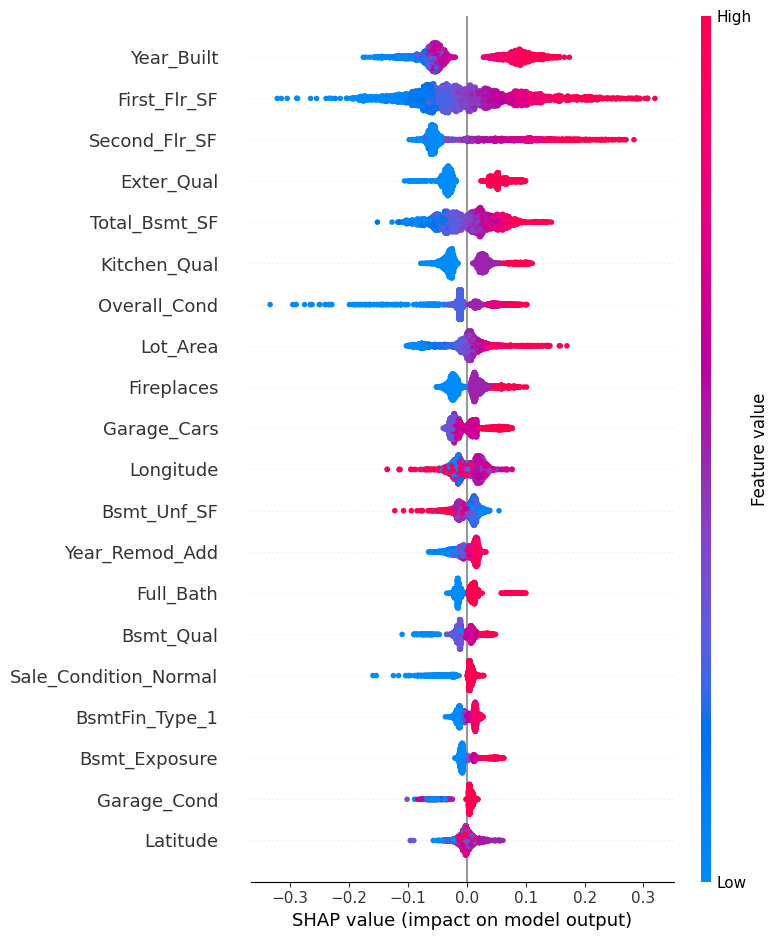

In [13]:
#vemos shap
import shap
XGB_optuna = fitted["XGB_Optuna"]
explainer = shap.Explainer(XGB_optuna  )
shap_values = explainer(X)
shap.summary_plot(shap_values, X)  # resumen de todas las características

RMSE total: 0.06
R² total: 0.9748


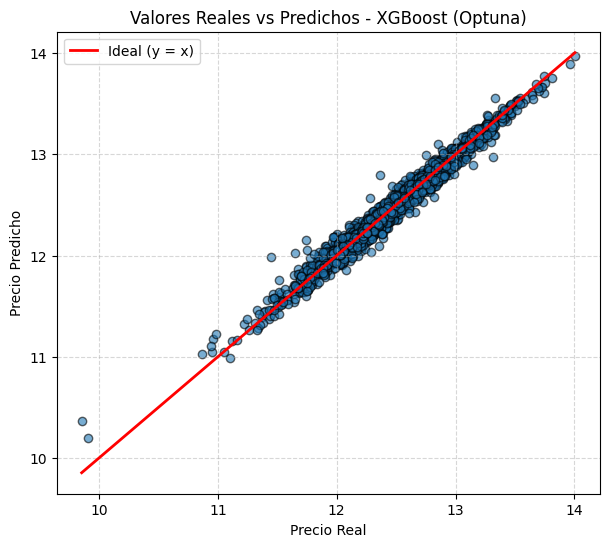

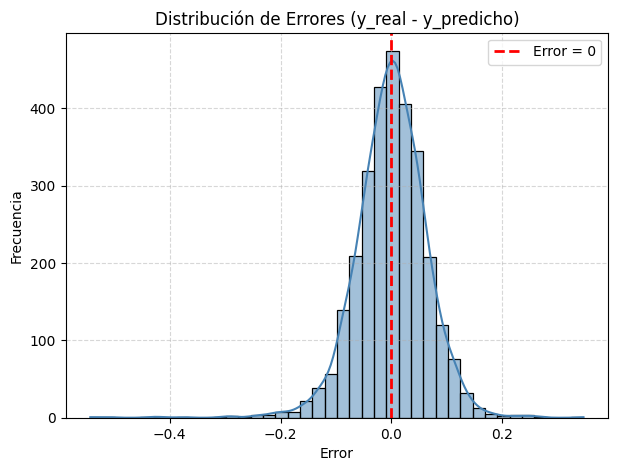

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# ======  Predicciones y errores  ======
y_pred = best_xgb_optuna.predict(X)
residuos = y_real - y_pred

# ======  Métricas  ======
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

print(f"RMSE total: {rmse:,.2f}")
print(f"R² total: {r2:.4f}")

# ======  1) Gráfico Real vs Predicho  ======
plt.figure(figsize=(7,6))
plt.scatter(y_real, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_real.min(), y_real.max()],
         [y_real.min(), y_real.max()],
         color="red", lw=2, label="Ideal (y = x)")
plt.title("Valores Reales vs Predichos - XGBoost (Optuna)")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ======  2) Distribución de Errores  ======
plt.figure(figsize=(7,5))
sns.histplot(residuos, bins=40, kde=True, color="steelblue")
plt.axvline(0, color="red", linestyle="--", lw=2, label="Error = 0")
plt.title("Distribución de Errores (y_real - y_predicho)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()





### Parámetros del modelo

In [19]:
# ----------------------------
# 2) Baseline, límites y costos (FIX)
# ----------------------------
# Requiere que ya existan:
# X, y_real, trained_feats, trained_stats (q05/median/q95), best_linear_model, best_gbr_model

ID_CASA = 987  # índice por fila (iloc)

# 1) Baseline: misma estructura (columnas) que se usó al entrenar
n = len(X)
idx = ID_CASA if 0 <= ID_CASA < n else 0  # fallback si se pasa de rango
baseline = X.iloc[idx].astype(float)

print("Caso base (features):")
print(baseline.to_string())

# 2) Elige el predictor (pipeline) que quieras evaluar como baseline
#    Puedes cambiar a best_linear_model si prefieres la lineal
PREDICTOR = XGB_optuna

# Predicción en log (nuestros modelos entrenan sobre y_log)
pred_log = float(PREDICTOR.predict(baseline.to_frame().T)[0])
precio_base_pred = float(np.expm1(pred_log))
print(f"\nPrecio base predicho: {precio_base_pred:,.0f}")

# Precio real de esa fila (en escala original; ya inflacionado si ajustaste antes)
precio_real = float(y_real.iloc[idx])
print(f"Precio real observado: {precio_real:,.0f}")

# 3) Cuantil 95% por feature (para cotas superiores)
q95 = trained_stats["q95"]  # viene de: trained_stats = DataFrame({q05, median, q95})

# 4) Costos por unidad (revisa unidades: p. ej., Gr_Liv_Area está en ft²)
default_costs = {
    "Gr_Liv_Area":     200,   # USD por ft²
    "Total_Bsmt_SF":    80,   # USD por ft²
    "Garage_Area":      60,   # USD por ft²
    "Garage_Cars":   17000,   # USD por puesto
    "Full_Bath":     25000,   # USD por baño
    "Fireplaces":      6000,  # USD por chimenea
    "Overall_Qual":   20000,  # USD por subir 1 punto (proxy)
    "KitchenQual_ord": 8000,  # USD por subir 1 nivel (TA→Gd→Ex) (ejemplo)
    "GarageFinish_ord":4000,  # USD por subir 1 nivel (Unf→RFn→Fin) (ejemplo)
}

# 5) "Room to grow" máximo (cuánto puedes mover vs baseline, si la norma/lote lo permite)
room = {
    "Gr_Liv_Area":     400.0,
    "Total_Bsmt_SF":   300.0,
    "Garage_Area":     250.0,
    "Garage_Cars":       1.0,   # sube a 2 si el lote lo permite
    "Full_Bath":         1.0,
    "Fireplaces":        1.0,
    "Overall_Qual":      1.0,
    "KitchenQual_ord":   1.0,
    "GarageFinish_ord":  1.0,
}

# 6) Construir cotas y costos por feature (solo para las usadas al entrenar)
bounds, costs = {}, {}
for f in trained_feats:
    base = float(baseline.get(f, X[f].median()))
    ub_by_room = base + room.get(f, 0.0)          # límite por “capacidad de cambio”
    ub_by_p95  = float(q95.get(f, base))          # límite por mercado (evita extrapolación)
    lb = base                                     # no bajamos de lo que ya tiene la casa base
    ub = max(lb, min(ub_by_room, ub_by_p95))      # asegura lb <= ub
    bounds[f] = (lb, ub)
    costs[f]  = float(default_costs.get(f, 0.0))

BUDGET = 200_000  # mismo orden de magnitud que tus costos (USD en este ejemplo)

print("\nLímites por feature (lb, ub):")
for f, (lb, ub) in bounds.items():
    if ub > lb:
        print(f"  {f:>16}: {lb:,.2f} → {ub:,.2f}")
    else:
        print(f"  {f:>16}: {lb:,.2f} (sin margen de aumento por p95/room)")

print("\nCostos unitarios usados:")
for f in trained_feats:
    if costs[f] > 0:
        print(f"  {f:>16}: {costs[f]:,.0f}")


Caso base (features):
Lot_Area                                                9819.000000
Land_Slope                                                 2.000000
Overall_Cond                                               5.000000
Year_Built                                              1977.000000
Year_Remod_Add                                          1977.000000
Mas_Vnr_Area                                               0.000000
Exter_Qual                                                 2.000000
Exter_Cond                                                 3.000000
Bsmt_Qual                                                  4.000000
Bsmt_Exposure                                              5.000000
BsmtFin_Type_1                                             6.000000
BsmtFin_SF_1                                               1.000000
Bsmt_Unf_SF                                                0.000000
Total_Bsmt_SF                                           1567.000000
Heating_QC                

### Guroby

In [20]:
# ======== 1️⃣ Configuración general ========
MODEL_NAME     = "XGB_Optuna"
OBJECTIVE_MODE = "profit"     # "price" | "profit" | "roi"
ROI_MIN        = 0.10         # sólo si OBJECTIVE_MODE == "roi"
PWL_K          = 25           # segmentos PWL para log→precio
BUDGET         = 80000        # 💰 presupuesto máximo

predictor = XGB_optuna       # usamos el modelo optimizado

print(f"→ Usando modelo: {MODEL_NAME}")


# ======== 2️⃣ Validaciones básicas ========
assert 'trained_feats' in globals(), "Falta 'trained_feats'."
feat_names_model = list(trained_feats)

for need in ("baseline", "bounds", "costs", "BUDGET"):
    assert need in globals(), f"Falta '{need}' en el entorno."

missing = [c for c in feat_names_model if c not in bounds or c not in costs or c not in baseline.index]
assert not missing, f"Faltan claves en bounds/baseline/costs para: {missing}"


# ======== 3️⃣ Modelo de optimización en Gurobi ========
m = gp.Model(f"ames_optuna_opt")
int_like = {"Garage_Cars","Full_Bath","Fireplaces","Overall_Qual","KitchenQual_ord","GarageFinish_ord"}

# Variables de decisión
x = {}
for c in feat_names_model:
    lb, ub = bounds[c]
    if c in int_like:
        lb_i, ub_i = int(np.floor(lb)), int(np.ceil(ub))
        if ub_i < lb_i: ub_i = lb_i
        x[c] = m.addVar(lb=lb_i, ub=ub_i, vtype=GRB.INTEGER, name=c)
    else:
        x[c] = m.addVar(lb=float(lb), ub=float(ub), vtype=GRB.CONTINUOUS, name=c)

# Restricción de presupuesto
cost_expr = gp.quicksum(costs[c] * (x[c] - float(baseline[c])) for c in feat_names_model)
m.addConstr(cost_expr <= float(BUDGET), name="Budget")

# DF 1xN con las variables del modelo
x_df = pd.DataFrame([[x[c] for c in feat_names_model]], columns=feat_names_model)

# Variable del predictor (log del precio)
y_pred_log = m.addVar(name="y_pred_log")

# 🔗 Vincular el modelo de ML (Optuna/XGB) con Gurobi
add_predictor_constr(
    gp_model=m,
    predictor=predictor,
    input_vars=x_df,
    output_vars=y_pred_log
)


# ======== 4️⃣ Función objetivo ========
if OBJECTIVE_MODE == "price":
    m.setObjective(y_pred_log, GRB.MAXIMIZE)
else:
    ymin, ymax = np.percentile(y_real, [1, 99])
    xs = np.linspace(ymin, ymax, PWL_K).tolist()
    ys = np.expm1(xs).tolist()

    price = m.addVar(name="price")
    m.addGenConstrPWL(y_pred_log, price, xs, ys, name="log_to_price")

    baseline_vec = pd.DataFrame([baseline[feat_names_model].to_dict()], columns=feat_names_model)
    price_before = float(np.expm1(predictor.predict(baseline_vec))[0])

    if OBJECTIVE_MODE == "profit":
        m.setObjective(price - cost_expr, GRB.MAXIMIZE)
    elif OBJECTIVE_MODE == "roi":
        m.addConstr(price - price_before >= ROI_MIN * cost_expr, name="ROImin")
        m.setObjective(price - cost_expr, GRB.MAXIMIZE)
    else:
        raise ValueError("OBJECTIVE_MODE debe ser 'price', 'profit' o 'roi'.")


# ======== 5️⃣ Resolver ========
m.Params.OutputFlag = 1
m.optimize()


# ======== 6️⃣ Reporte de resultados ========
if m.SolCount > 0:
    baseline_vec = pd.DataFrame([baseline[feat_names_model].to_dict()], columns=feat_names_model)
    price_before_rep = float(np.expm1(predictor.predict(baseline_vec))[0])
    price_after_rep  = float(np.expm1(y_pred_log.X)) if OBJECTIVE_MODE == "price" else float(price.X)

    deltas = {c: x[c].X - float(baseline[c]) for c in feat_names_model}
    spent  = float(cost_expr.getValue())
    profit = price_after_rep - price_before_rep - spent
    roi    = (profit / spent) if spent > 0 else float('nan')

    print("\n=== SOLUCIÓN CASA ÓPTIMA ===")
    print(f"Modelo usado   : {MODEL_NAME}")
    print(f"Objetivo       : {OBJECTIVE_MODE}")
    print(f"Precio antes   : {price_before_rep:,.0f}")
    print(f"Precio después : {price_after_rep:,.0f}")
    print(f"Gasto estimado : {spent:,.0f}  (≤ presupuesto {BUDGET:,.0f})")
    print(f"Ganancia       : {profit:,.0f}   |  ROI: {roi:,.2f}\n")

    print("Cambios en variables accionables:")
    for c in feat_names_model:
        if abs(deltas[c]) > 1e-6:
            print(f" - {c:20s}: {x[c].X:10.3f}  (Δ={deltas[c]:+10.3f})")
else:
    print("❌ No se encontró solución factible.")


→ Usando modelo: XGB_Optuna
Set parameter Username
Set parameter LicenseID to value 2670211
Academic license - for non-commercial use only - expires 2026-05-23


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 3032 rows, 8390 columns and 10339 nonzeros
Model fingerprint: 0x1cb2dfcc
Model has 1633 simple general constraints
  1632 INDICATOR, 1 PWL
Variable types: 1083 continuous, 7307 integer (7304 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 3e+04]
  Bounds range     [1e+00, 1e+04]
  RHS range        [5e-05, 3e+05]
  PWLCon x range   [1e+01, 1e+01]
  PWLCon y range   [1e+05, 6e+05]
  GenCon rhs range [7e-08, 2e+03]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 2410 rows and 7541 columns
Presolve time: 0.07s
Presolved: 622 rows, 849 columns, 2335 nonzeros
Variable types: 139 continuous, 7